In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import datetime
import datetime as dt
import numpy as np
import random
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
from scipy.stats import norm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sns.set_style("ticks")

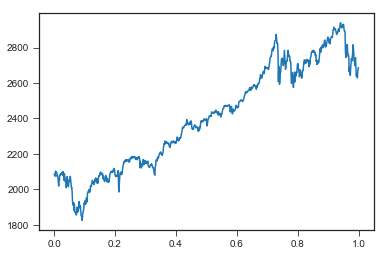

In [2]:
#### Reading in Euro/Dollar Exchange Quotes
euro1 = pd.read_csv("eurcsv.csv")
jpy1 = pd.read_csv("jpy.csv")
crude1  = pd.read_csv("Crude.csv")
intc1 = pd.read_csv("intc.csv")
nflx1 = pd.read_csv("nflx.csv")
emini1 = pd.read_csv("e-mini.csv")


#Defining Dates and Closing Prices
euro = euro1['Price']
jpy = jpy1['Price']
crude = crude1['Price']
intc = intc1["Adj Close"]
nflx = nflx1["Adj Close"]
e_mini = emini1['Price']
x = np.linspace(0,1,814)
plt.plot(x,e_mini)


In [3]:
#Stru

def zero(basket):
    data  = np.copy(basket)
    hold = []
    for i in range(len(data)):
        lens = len(data[i])
        hold.append(lens)
    max_length = np.max(hold)
    for i in range(len(data)):
        while len(data[i]) <= max_length-1:
            replaced = np.insert(data[i],len(data[i]),0)
            data[i] = replaced
    stacked = np.column_stack(data)
    return stacked


def combine(structured_rets):
    combined_returns = []
    for i in range(len(structured_rets)):
        num_zeros = (structured_rets[[i],:] == 0).sum()
        column_sum = sum(structured_rets[i])
        length = len(structured_rets[i])
        average = column_sum/(length)
        combined_returns.append(average)
    
    running_sum = np.cumsum(combined_returns)
    return combined_returns



In [4]:
def tester(price_in,technical,long_or_short):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    twenty_six = price_in.ewm(span=26).mean()
    twelve = price_in.ewm(span=12).mean()
    macd = twelve - twenty_six
    delta_macd = macd.pct_change(periods=2)
    slope = []
#     for i in range(len(macd)):
#         if i == 0:
#             slope.append(i)
#         else:
#             temp_slope = macd[i]-macd[i-1]
#             slope.append(temp_slope)
    if long_or_short == "long":
        for i in range(len(price_in)-1):
            if delta_macd[i] > technical:
                buys.append(i)
    else:
        for i in range(len(price_in)-1):
            if delta_macd[i] < technical:
                shorts.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
    
#    plt.plot(np.cumsum(rets))
    if long_or_short == "long":
        total_return = np.cumsum(rets)
        std_rets = np.std(rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_rets))*-1
        end_return = (end_return1)/VAR_95
        
    else:
        total_return = np.cumsum(s_rets)
        end_return = total_return[-1]
        std_s_rets = np.std(s_rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(s_rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_s_rets))*-1
        end_return = (end_return1)/VAR_95

    max_macd = np.percentile(delta_macd[5:],85)
    min_macd = np.percentile(delta_macd[5:],15)

    return end_return, total_return, min_macd, max_macd



def random_walker(n,ls,close):
    starter = [0]    
    x_start, indicator, min_ind, max_ind = tester(close,starter[-1],str(ls))
    for i in range(n):
        test_x = np.random.uniform(min_ind,max_ind)
        random_return, indicator, minn,maxx = tester(close,test_x,str(ls))
        test_return, notimportant, minn,maxx = tester(close,starter[-1],str(ls))
        if random_return > test_return:
            starter.append(test_x)
    x,y,minn,maxx = tester(close,starter[-1],str(ls))
        
    return starter[-1]

In [5]:
def back_testing(price_in,long_indicator,short_indicator):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    twenty_six = price_in.ewm(span=26).mean()
    twelve = price_in.ewm(span=12).mean()
    macd = twelve - twenty_six
    delta_macd = macd.pct_change(periods=2)
    mix = []
    mix_port = []
    slope = []
    for i in range(len(macd)):
        if i == 0:
            slope.append(i)
        else:
            temp_slope = macd[i]-macd[i-1]
            slope.append(temp_slope)

    for i in range(len(price_in)-1):
        if delta_macd[i] > long_indicator:
            buys.append(i)
            mix.append(i)
        elif delta_macd[i] < short_indicator:
            shorts.append(i)
            mix.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
#     for i in mix:
#         j = int(i)
#         j1 = int(i+1)
#         mix_return = ((price_in[j1] - price_in[j])/price_in[j])*100
#         mix_port.append(mix_return)        
        
#     for i in range(len(price_in)-1):
#         z = int(i)
#         z1 = int(i+1)
#         base = ((price_in[z1] - price_in[z])/price_in[z])*100
#         benchmark.append(base)

#     x_bench = np.linspace(0,1,len(benchmark))
    x_strat = np.linspace(0,1,len(rets))   
    x_short = np.linspace(0,1,len(s_rets))
    mix_port = np.concatenate((rets,s_rets))
    x_mix = np.linspace(0,1,len(mix_port))
#    fig, ax = plt.subplots(figsize=(12,5))

#     ax.plot(x_strat, np.cumsum(rets),label="Long Strategy")
#     ax.plot(x_bench, np.cumsum(benchmark),label="Benchmark")
#     ax.plot(x_short, np.cumsum(s_rets),label="Short Strategy")
#     ax.plot(x_mix, np.cumsum(mix_port),label="Mix Portfolio")

# #    ax2 = ax.twinx()
# #    ax2.plot(np.linspace(0,1,len(macd)), macd, 'r')
#     ax.yaxis.set_major_formatter(PercentFormatter())    
#     ax.legend(fontsize=15)
#     print("Strategy Return = %",sum(rets))
#     print("Total Return Outright = %",sum(benchmark))
    
#     #RISK ASSESMENT BENCHMARK
#     delta_returns = price_in.pct_change()
#     mean_returns = np.mean(delta_returns)
#     std_returns = np.std(delta_returns)
#     VAR_95 = norm.ppf(1-0.95,mean_returns, std_returns)*100
#     print("Benchmark VAR @ confidence Level = 95% Level", VAR_95)
    
#     #RISK ASSESMENT STRATEGY
#     #delta_returns_strat = price_in.pct_change()
#     mean_returns_strat = np.mean(rets)
#     std_returns_strat = np.std(rets)
#     VAR_95_strat = norm.ppf(1-0.95,mean_returns_strat, std_returns_strat)
#    print("Strategy VAR @ confidence Level = 95% Level", VAR_95_strat)
    return mix_port

    

In [6]:
import quandl
quandl.ApiConfig.api_key = "NbXifkuiz3ymhZj7V8-E"
aapl1 = quandl.get("WIKI/AAPL", start_date="2014-10-17", end_date="2018-11-15")
curr = quandl.get("FED/RXI_N_A_SZ")

len(curr)

48

544


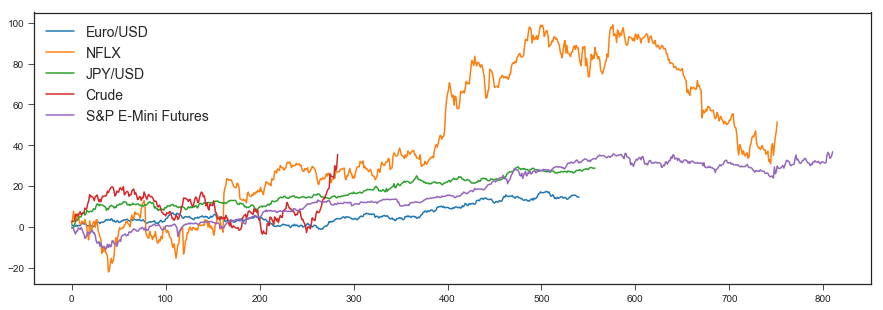

In [7]:
#labels = ("Euro/USD","NFLX","USD/JPY","Crude","E-Mini")
def best_indicator(n,prices,labels):
    long_ind = random_walker(n,"long",prices)
    short_ind = random_walker(n,"short",prices)
    returns = back_testing(prices,long_ind,short_ind)
    plt.plot(np.cumsum(returns),label=labels)
    plt.legend(fontsize=14)
    return returns
plt.figure(figsize=(15,5))

euro_returns = best_indicator(150,euro,"Euro/USD")
nflx_returns = best_indicator(150,nflx,"NFLX")
#intc_returns = best_indicator(100,intc)
jpy_returns = best_indicator(150,jpy,"JPY/USD")
crude_returns = best_indicator(150,crude,"Crude")
e_mini_returns = best_indicator(150,e_mini,"S&P E-Mini Futures")

print(len(euro))

-0.6665472779369628
82.00991044776119
0.3899241237545641
-0.21728850427956675
-2.3555239038890265
-0.9665899761652542
29.734992679355784
-1.1828206329301751
0.7875130018722697
-2.985346503302754
-1.9047707231040563
0.6496679239893269
-0.2642860830576527
0.8027861659445152
-1.2258727626869643
2.072338016207226
-0.03147378617923716
-1.171888763417048
2.256700355455268
-2.4370522710108937
-0.19882589578070917
-1.1020887653648892
14.273046285573919
-1.1051424251246749
-10.350836562468226
1.084939234838041
-0.5832170152954153
-1.1293456374818265
2.90347513267717
-5.023914225309574
-1.7761598871040163
-2.1763376781658317
-0.8417992911392433
-1.8803243591002576
-1.2321077406754182
13.409610250934332
-1.3365678346810421
5.35444653412144
-1.7429007494358368
-1.9016992472885332
-1.8044580312154357
-1.2768761904761905
7.539031029480606
-1.0150070018046435
30.549660045327286
-0.8366848394063959
-0.5991884214797782
13.845381526104418
-2.5353521512743216
-0.6727207498094084
0.21486731449288266
-1.92

C:\Users\jackb\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


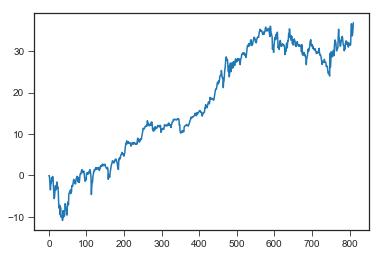

In [13]:
plt.plot(np.cumsum(e_mini_returns))
for i in range(len(e_mini_returns)-1):
    x = ((e_mini_returns[i+1]-e_mini_returns[i])/e_mini_returns[i])
    print(x)

34.630775463001534
10.80343550202144


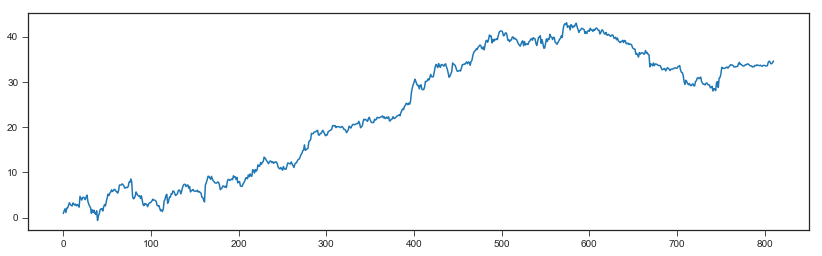

In [34]:
port_returns = (euro_returns,nflx_returns,jpy_returns,crude_returns,e_mini_returns)
structured_returns = zero(port_returns)
total_returns = combine(structured_returns)
cum_returns = np.cumsum(total_returns)

plt.figure(figsize=(14,4))

plt.plot(np.cumsum(total_returns))
roi = cum_returns[-1]/(len(cum_returns)/253)
print(cum_returns[-1])
print(roi)


In [ ]:
# date = pd.to_datetime(sp['Date'])
fig, ax1 = plt.subplots(figsize=(13,5))
ax1.plot(date, macd, 'b-')
ax2 = ax1.twinx()
ax2.plot(date, close, 'r')
ax2.set_ylabel(color='r')
ax2.tick_params('y', colors='r')
fig.tight_layout()